In [1]:
# Standard libraries
import sys
import math
import random
import time
import os

# Third-party imports
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

import importlib
from yapf.yapflib.yapf_api import FormatCode
import GPUtil

# Project imports
import ephesus
import utils

In [2]:
main_path = '/home/rfradkin/xom/'
raw_tess_path = '/scratch/data/tess/lcur/spoc/raws/'
tess_metad_path = '/data/scratch/data/tess/meta/'
xom_data_path = '/data/scratch/data/moon/'

### GPU Setup

In [3]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |
|  1 |  0% | 17% |
|  2 |  0% |  9% |
|  3 |  0% |  9% |


In [4]:
# All GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)
mirror_strat = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


### Data Preprocessing

In [5]:
###      DOUBLE CHECK      ###
detec_type = 'plane_moon_cut_injec'

In [6]:
datas = 'padde_cuts-not_detre-1_3-1638827846.pkl'

with open(f'{xom_data_path}padde_cuts/{datas}','rb') as f:
    raw_x_data = pkl.load(f)

In [7]:
numbe_sampl = -1

# Create a shuffled sample of the data
rando_shuff_x_data = raw_x_data[utils.retur_rando_sampl(
    numbe_sampl, len(raw_x_data))]
np.random.shuffle(rando_shuff_x_data)

# Normalize the data from 0 to 1
norma_full_x_data = np.copy(rando_shuff_x_data)
x_data = np.copy(rando_shuff_x_data[:, :-1, 1].astype(float))

for i in range(len(x_data)):
    chang_slots = np.where(x_data[i] != 0)[0]
    x_data[i, chang_slots] = utils.norma_data(x_data[i, chang_slots])
    norma_full_x_data[i, :-1, 1] = x_data[i]

x_data = np.expand_dims(x_data, 2)

# Create the corresponding y dataset
y_data = np.zeros(len(norma_full_x_data))
for i in range(len(norma_full_x_data)):
    y_data[i] = norma_full_x_data[i, -1, 1][detec_type]

print(
    f'{sum(y_data)/len(y_data):.2%} of the dataset contains a full injection')

20.98% of the dataset contains a full injection


In [8]:
# Split the data into training and testing

stop = len(x_data) - len(y_data) % 100
split = int(stop * 0.7)
    
x_train_np = np.array(x_data[:split])
full_x_train = norma_full_x_data[:split]
x_test_np = np.array(x_data[split:stop])
full_x_test = norma_full_x_data[split:stop]
y_train_np = y_data[:split]
y_test_np = y_data[split:stop]

In [9]:
# Mask the data
masking = layers.Masking(mask_value=0., input_shape = (1900, 1))

x_train_unmas = tf.convert_to_tensor(x_train_np)
x_test_unmas = tf.convert_to_tensor(x_test_np)
y_train = tf.convert_to_tensor(y_train_np)
y_test = tf.convert_to_tensor(y_test_np)
x_train = masking(x_train_unmas)
x_test = masking(x_test_unmas)

### Training

In [10]:
# Callbacks

# tensorboard = TensorBoard(log_dir=f'{main_path}tensorboard/{dataset}_{int(time.time())}')
early_stopp = EarlyStopping(monitor='val_accuracy', patience=5)
resto_valid_accur = utils.resto_best_valid_accur()

callb = [resto_valid_accur, early_stopp]#, tensorboard]

#### New Model

#### Continue Training

In [14]:
model_file = f'padde_cuts-1_3-1637740011.1509235.pkl-0-1637955911.7113917.h5'

In [15]:
l2_norma_gradi = 0.25
learn_rate = 3e-4
with mirror_strat.scope(): 
    model = tf.keras.models.load_model(f'{xom_data_path}plane_moon_model/{model_file}')
    opt = tf.keras.optimizers.Nadam(learning_rate=learn_rate,
                                    clipnorm=l2_norma_gradi)
    model.compile(loss='BinaryCrossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1900, 64)          12864     
_________________________________________________________________
gru_1 (GRU)                  (None, 176)               127776    
_________________________________________________________________
dense (Dense)                (None, 160)               28320     
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 112)               18144     
_________________________________________________________________
dropout_1 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [17]:
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=20,
                    callbacks=callb,
                    validation_data=(x_test, y_test))

Epoch 1/20
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 13 all-reduces with algorithm = nccl, num_packs = 1
8624/8624 [==============================] - 1362s 154ms/step - loss: 0.2789 - accuracy: 0.9086 - val_loss: 0.2797 - val_accuracy: 0.9081
Epoch 2/20
8624/8624 [==============================] - 1338s 155ms/step - loss: 0.2867 - accuracy: 0.9080 - val_loss: 0.2921 - val_accuracy: 0.9077
Epoch 3/20
8624/8624 [==============================] - 1314s 152ms/step - loss: 0.2941 - accuracy: 0.9074 - val_loss: 0.2748 - val_accuracy: 0.9065
Epoch 4/20
8624/8624 [==============================] - 1312s 152ms/step - loss: 0.2952 - accuracy: 0.9071 - val_loss: 0.2733 - val_accuracy: 0.9085
Epoch 5/20
8624/8624 [==============================] - 1329s 154ms/step - loss: 0.3091 - accuracy: 0.8995 - val_loss: 0.5698 - val_accuracy: 0.7691
Epoch 6/20
8624/8624 [==============================] - 1312s 152ms/step - loss: 0.

### Testing

In [10]:
start = 0
stop = None

x_full_predi_data = full_x_test[start:stop]
x_predi_data = x_test[start:stop]
y_predi_data = y_test_np[start:stop]

In [11]:
model_file = f'padde_cuts-not_detre-1_3-1638827846.pkl-0-1638968073.h5'
model = tf.keras.models.load_model(f'{xom_data_path}plane_moon_model/{model_file}');

In [12]:
# Make predictions
predi = model.predict(x_predi_data).squeeze()

In [13]:
a = np.array([1,2,3])

In [14]:
tot=0
num=0
for i in range(len(data)):
    if data[i, -1, 1]['ratio_plane_stell_radiu']

SyntaxError: invalid syntax (<ipython-input-14-ff60de73de4e>, line 4)

In [ ]:
len(a)

In [ ]:
calcu_varia(x_full_predi_data, 'stell_mass')

In [ ]:
a = np.array([1,1.,1,1])

In [ ]:
calcu_varia(a)

In [82]:
def calcu_varia(data, featu=None):
    '''Calculates the variance of a numerical feature.'''
    featu_value = []
    if featu is not None:
    # Extract the features
        for i in range(len(data)):
            curre_featu = data[i, -1, 1][featu]
            if curre_featu is not None and isinstance(curre_featu, (int, float)):
                        featu_value.append(curre_featu)
        featu_value = np.array(featu_value)
    else:
        featu_value = data
    # Calculate the variance
#     print(type(featu_value))
    featu_value -= np.mean(featu_value)
    featu_value = np.square(featu_value)
    varia = np.sum(featu_value) / len(featu_value)

    # Return the square root of the variance
    return np.sqrt(varia)

In [ ]:
def calcu_preci_recal(binne_data, numbe_inter=1000)

In [ ]:
def fucked_up_auc_shit()

In [96]:
importlib.reload(utils);

In [97]:
cutof = 0.2

[[4.49957614e+03 1.74412724e-01]
 [6.24491034e+03 2.41974584e-01]
 [9.34075392e+03 2.36132455e-01]
 [1.24467834e+04 7.45970126e-02]
 [2.44127273e+04 1.73777132e-01]
 [2.62550588e+04 2.24888053e-01]
 [2.90655556e+04 2.12394272e-01]
 [3.10237846e+04 2.48501298e-01]
 [3.41666579e+04 2.51519533e-01]
 [4.12951667e+04 3.18591408e-01]
 [4.48750000e+04 7.96478520e-01]
 [4.99268716e+04 2.71825697e-01]
 [5.24600000e+04 9.55774224e-01]
 [5.84500000e+04 4.77887112e-01]]


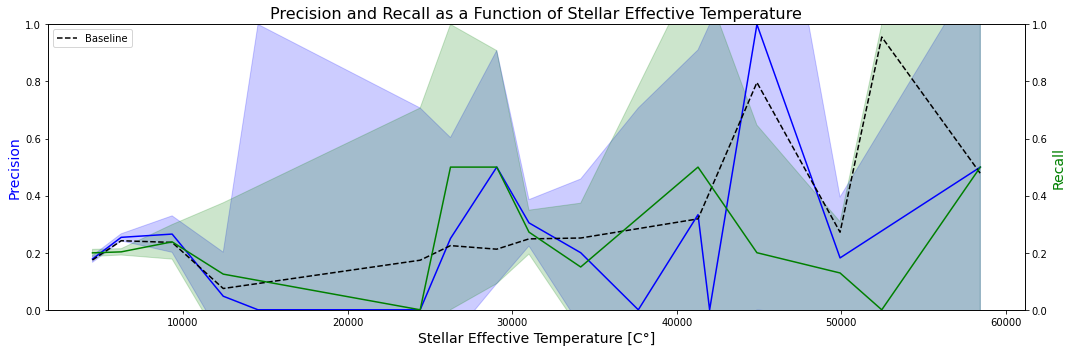

In [111]:
utils.show_featu_preci_recal(x_full_predi_data,
                       predi,
                       y_predi_data,
                       cutof,
                       featu='stell_effec_tempe',
                       bins=20,
                       equal_width_bins=True,
                       stand_axis=True)
# Possible third axis with AUC
# AUC in red overplotted

In [21]:
x_full_predi_data[25478, -1, 1]

{'curve_injec': False,
 'curve_type': 'Light Curve',
 'cut_times': None,
 'cut_trans': False,
 'cut_numbe': 9,
 'cut_start_index': 17884,
 'detre_time_scale': None,
 'detre_type': None,
 'eb': None,
 'file_name': 'tess2018206045859-s0001-0000000055659311-0120-s_lc.fits',
 'forma_names': {'curve_injec': 'Curve Injected',
  'curve_type': 'Curve Type',
  'cut_times': 'Cut Times',
  'cut_trans': 'Cut Transit',
  'cut_numbe': 'Cut Number',
  'cut_start_index': 'Cut Start Index',
  'detre_time_scale': 'Detrended Time Scale [days]',
  'detre_type': 'Detrended Type',
  'eb': 'Eclipsing Binary',
  'file_name': 'File Name',
  'injec_times': 'Injection Times',
  'inter_type': 'Interpolation Spline',
  'initi_paddi': 'Initial Padding',
  'linea_limb_darke_coeff': 'Linear Limb Darkening Coefficient',
  'max_ampli': 'Max Amplitude',
  'model_file': 'Model File',
  'moon_eccen': 'Moon Eccentricity',
  'moon_epoch': 'Moon Epoch [BJD]',
  'moon_incli': 'Moon Inclination [°]',
  'moon_mass': 'Moon Mass 

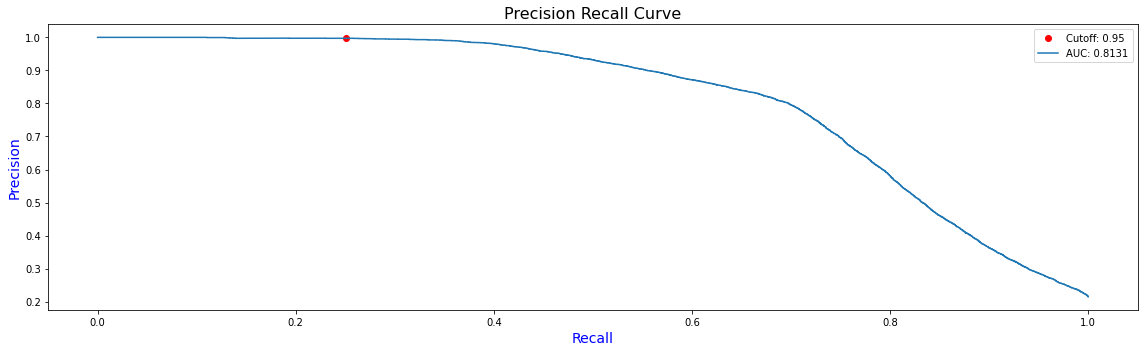

In [30]:
utils.show_preci_recal(predi, y_predi_data, cutof)

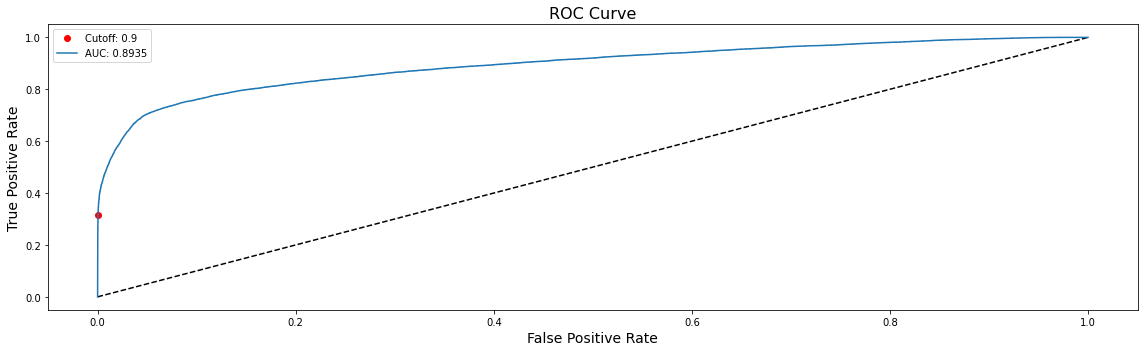

In [26]:
utils.show_roc(predi, y_predi_data, cutof)

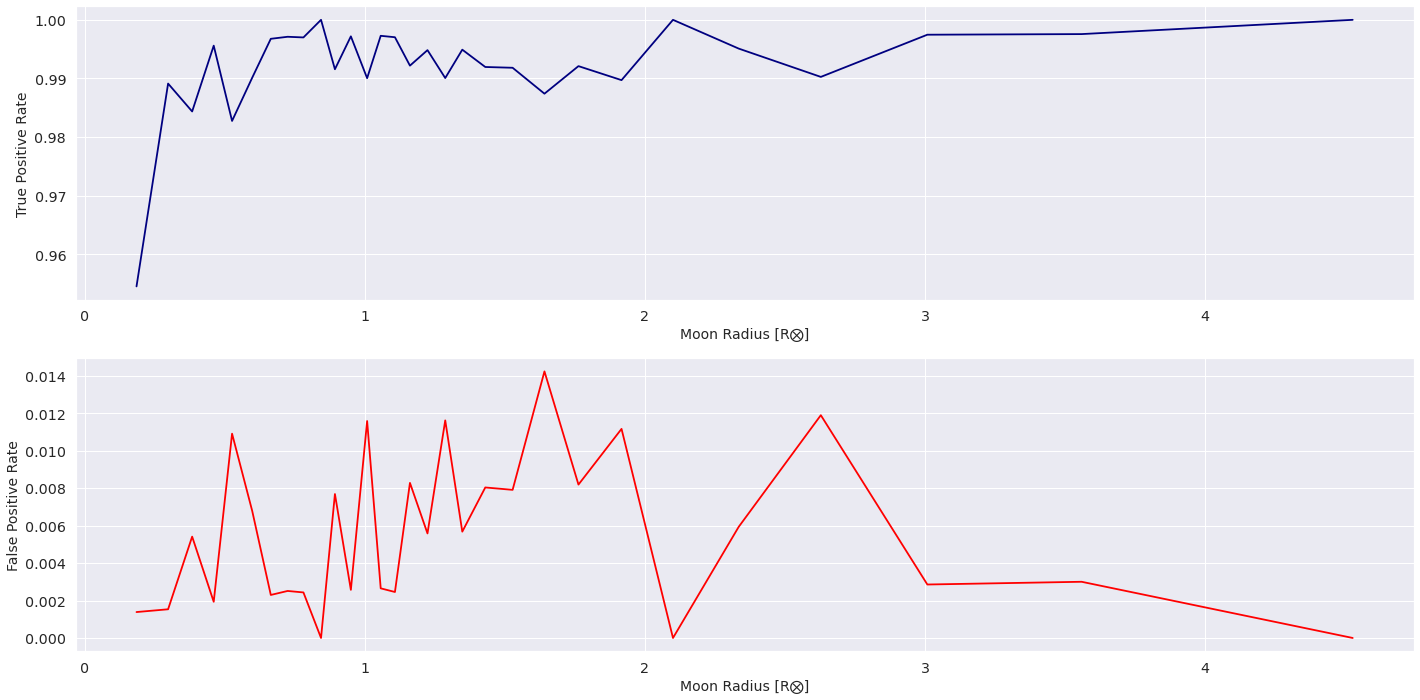

In [32]:
utils.show_tpr_fpr(x_full_predi_data, predi, cutof, 'moon_radiu', 30, False)

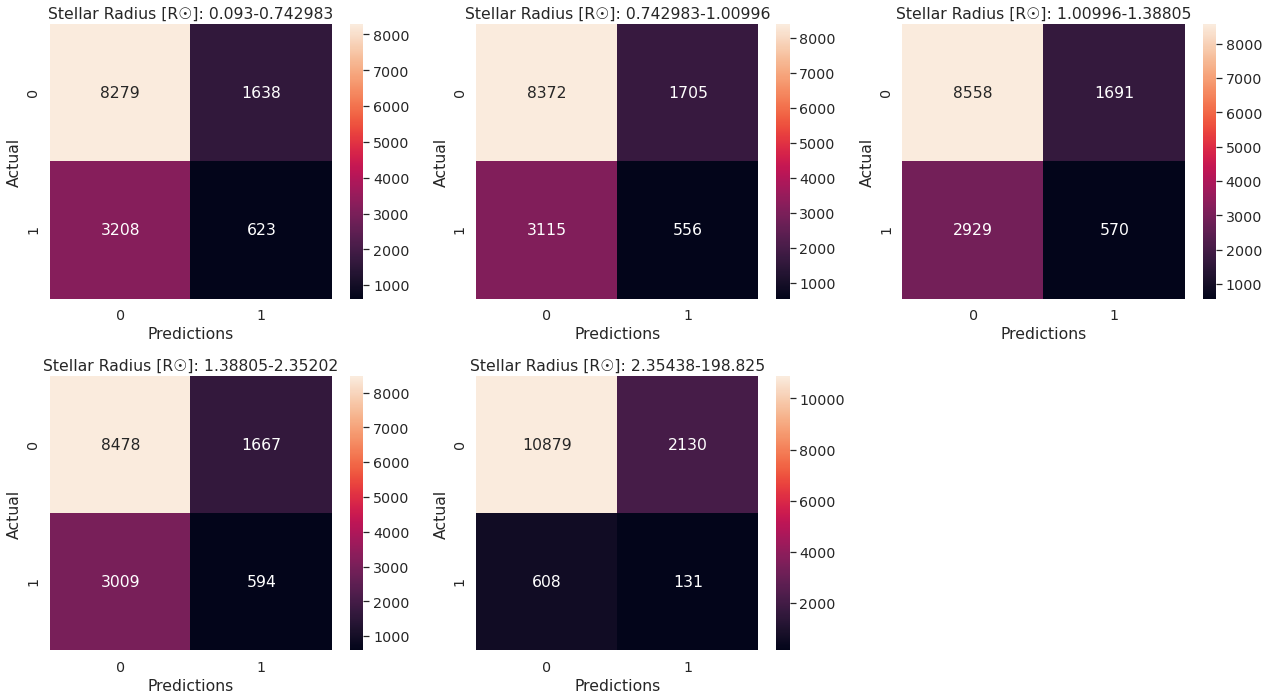

In [21]:
utils.show_confu_matri(x_full_predi_data, predi, cutof, 'stell_radiu', 5)

#### Formatting